In [1]:
#RL
from tensorforce import Runner
from tensorforce import Environment
from tensorforce import Agent
#basic
import numpy as np
import pandas as pd
#sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#image processing
from skimage.future import graph
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import felzenszwalb
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray
from skimage.transform import resize
from skimage.transform import rescale
#visialization
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_palette("Set2")
#ontology
import owlready2 as owl

In [2]:
>>> from dynamicgem.embedding.ae_static import AE
>>> from dynamicgem.graph_generation import dynamic_SBM_graph
>>> node_num = 1000
>>> community_num = 2
>>> node_change_num = 10
>>> length =5
>>> dynamic_sbm_series = dynamic_SBM_graph.get_community_diminish_series_v2(node_num,
                                                                        community_num,
                                                                        length,
                                                                        1,
                                                                        node_change_num)
>>> embedding = AE(d=dim_emb,
               beta=5,
               nu1=1e-6,
               nu2=1e-6,
               K=3,
               n_units=[500, 300, ],
               n_iter=epochs,
               xeta=1e-4,
               n_batch=100,
               modelfile=['./intermediate/enc_modelsbm.json',
                          './intermediate/dec_modelsbm.json'],
               weightfile=['./intermediate/enc_weightssbm.hdf5',
                           './intermediate/dec_weightssbm.hdf5'])

ImportError: cannot import name 'SGD' from 'keras.optimizers' (/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/keras/optimizers.py)

# help functions

In [5]:
# img = Image.fromarray(States[0], 'RGB')
# img.save("normal.png")
# img.show()

In [6]:
def to_shape(a, shape):
    y_, x_ = shape
    y, x = a.shape[0:2]
    y_pad = (y_-y)
    x_pad = (x_-x)
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                     (x_pad//2, x_pad//2 + x_pad%2),
                    (0,0)
                    ),
                  mode = 'constant')

In [7]:
def make_video(States,name="test",width=210,height=160,channel=3,fps=30):
    width = 210
    height = 160
    channel = 3

    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    video = cv2.VideoWriter(name+'.avi', fourcc, float(fps), (height, width))

    for i in range(States.shape[0]):
        video.write(States[i])

    video.release()

In [8]:
def visualize_objects(label_image,image):
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 5:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Agent and Enviroment

In [52]:
# OpenAI-Gym environment specification
environment = Environment.create(
       environment='gym', level='SpaceInvaders-v4', max_episode_timesteps=100)

# PPO agent specification
agent = dict(
    agent='ppo',
    # Automatically configured network
    network='auto',
    # Parameters
    memory= 1700 ,
    batch_size = 16 , 
    # Reward estimation
    discount=0.95, predict_terminal_values=False,
    reward_processing=None,
    # Baseline network and optimizer
    #baseline=dict(type='auto', size=32, depth=1),
    #baseline_optimizer=dict(optimizer='adam', learning_rate=1e-3, multi_step=10),
    # Regularization
    l2_regularization=0.0, entropy_regularization=0.0,
    # Preprocessing
    state_preprocessing='linear_normalization',
    # Exploration
    exploration=0.0, variable_noise=0.0,
    # Default additional config values
    config=None,
    # Save agent every 10 updates and keep the 5 most recent checkpoints
    saver=dict(directory='model', frequency=10, max_checkpoints=5),
    # Log all available Tensorboard summaries
    summarizer=dict(directory='summaries', summaries='all'),
    # Do record agent-environment interaction trace
    recorder=dict(directory='record')
)
# or: Agent.create(agent='ppo', environment=environment, ...)
# with additional argument "environment" and, if applicable, "parallel_interactions"

# Initialize the runner
runner = Runner(agent=agent, environment=environment)

# Train for 200 episodes
runner.run(num_episodes=5)
runner.close()


/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment SpaceInvaders-v4 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/SpaceInvaders-v5`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


Episodes:   0%|          | 0/5 [00:00, return=0.00, ts/ep=0, sec/ep=0.00, ms/ts=0.0, agent=0.0%]

# Dimension Reduction

In [9]:
trace=np.load("./record/trace-000000000.npz")

In [10]:
trace["states"]

trace["terminal"]

trace["reward"]

trace["actions"]

array([5, 0, 4, 1, 3, 4, 3, 4, 0, 2, 1, 0, 1, 5, 4, 1, 2, 0, 4, 1, 0, 2,
       5, 4, 1, 3, 1, 4, 5, 2, 2, 4, 3, 4, 3, 4, 5, 0, 2, 2, 2, 1, 3, 3,
       1, 3, 0, 3, 2, 3, 4, 5, 3, 0, 3, 2, 2, 2, 4, 4, 2, 1, 1, 4, 4, 2,
       2, 2, 5, 0, 4, 0, 2, 5, 1, 3, 3, 3, 0, 5, 5, 5, 2, 3, 5, 0, 5, 4,
       0, 1, 2, 3, 5, 0, 0, 0, 0, 1, 1, 5])

In [11]:
States=trace["states"]

In [12]:
trace["reward"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [13]:
trace["actions"]

array([5, 0, 4, 1, 3, 4, 3, 4, 0, 2, 1, 0, 1, 5, 4, 1, 2, 0, 4, 1, 0, 2,
       5, 4, 1, 3, 1, 4, 5, 2, 2, 4, 3, 4, 3, 4, 5, 0, 2, 2, 2, 1, 3, 3,
       1, 3, 0, 3, 2, 3, 4, 5, 3, 0, 3, 2, 2, 2, 4, 4, 2, 1, 1, 4, 4, 2,
       2, 2, 5, 0, 4, 0, 2, 5, 1, 3, 3, 3, 0, 5, 5, 5, 2, 3, 5, 0, 5, 4,
       0, 1, 2, 3, 5, 0, 0, 0, 0, 1, 1, 5])

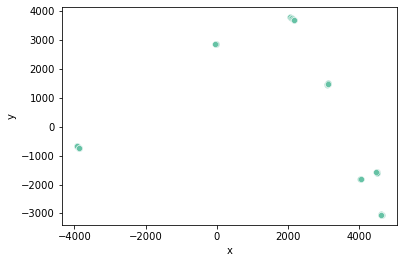

In [14]:
pca = PCA(n_components=20)

pca.fit(States.reshape(100,-1))

X = pca.transform(States.reshape(100,-1))

#visualize
df = pd.DataFrame(X[:,:2], columns=["x", "y"])
sns.scatterplot(data=df,x="x",y="y")

X=pca.inverse_transform(X)

X=X.reshape(States.shape)

X=X.astype("uint8")

In [15]:
np.mean((States[0] - X[0]) ** 2)

0.010952380952380953

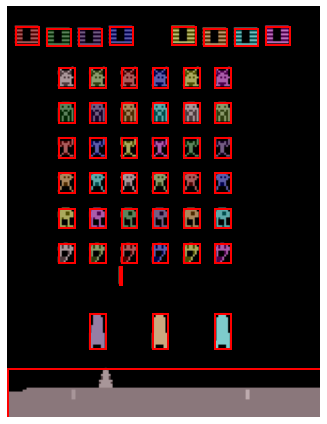

In [19]:
image=States[80]

def find_objects(image):
    img = rgb2gray(image)

    # apply threshold
    thresh = threshold_otsu(img)
    reg = closing(img > thresh, square(3))

    # label image regions
    label_image = label(reg)
    
    return label_image

label_image=find_objects(image)
visualize_objects(label_image,image)

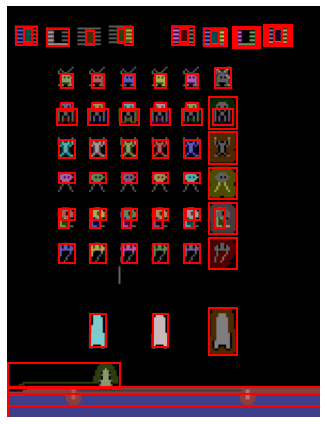

In [17]:
image=States[80]

def find_objects2(image,threshold=80,scale=2):
    reg = felzenszwalb(image,scale=scale)

    # label image regions
    label_image = label(reg)
    g = graph.rag_mean_color(image, label_image)
    final_labels = graph.cut_threshold(reg + 1, g, threshold)
    label_image = label(final_labels)
    
    return label_image

label_image=find_objects2(image)
visualize_objects(label_image,image)

In [20]:
regions=regionprops(label_image)

m_w=max([reg.image.shape[0] for reg in regions])

m_h=max([reg.image.shape[1] for reg in regions])

objects=np.array([to_shape(image[reg.slice],(m_w,m_h)) for reg in regions])

In [21]:
X=objects.reshape(objects.shape[0],-1)

# Clustering

In [22]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

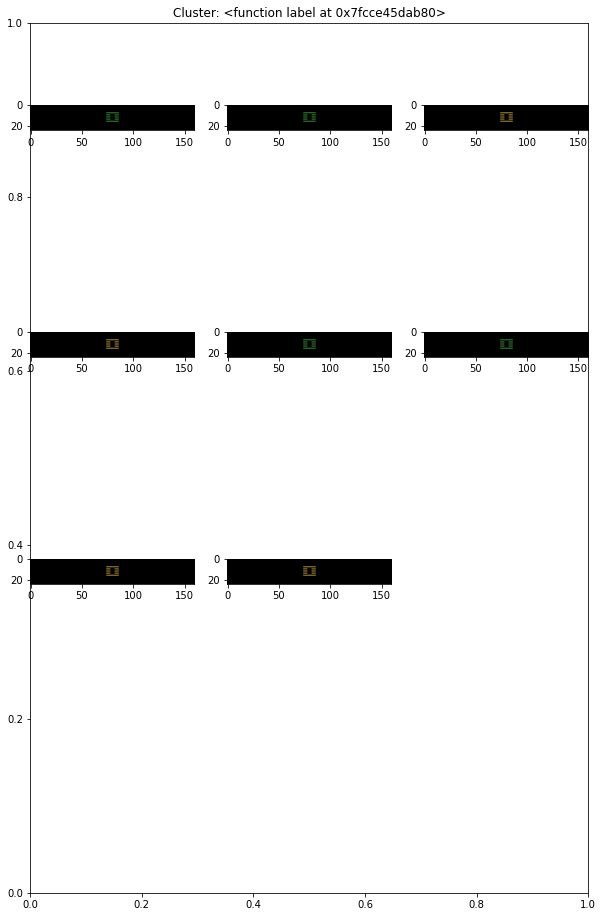

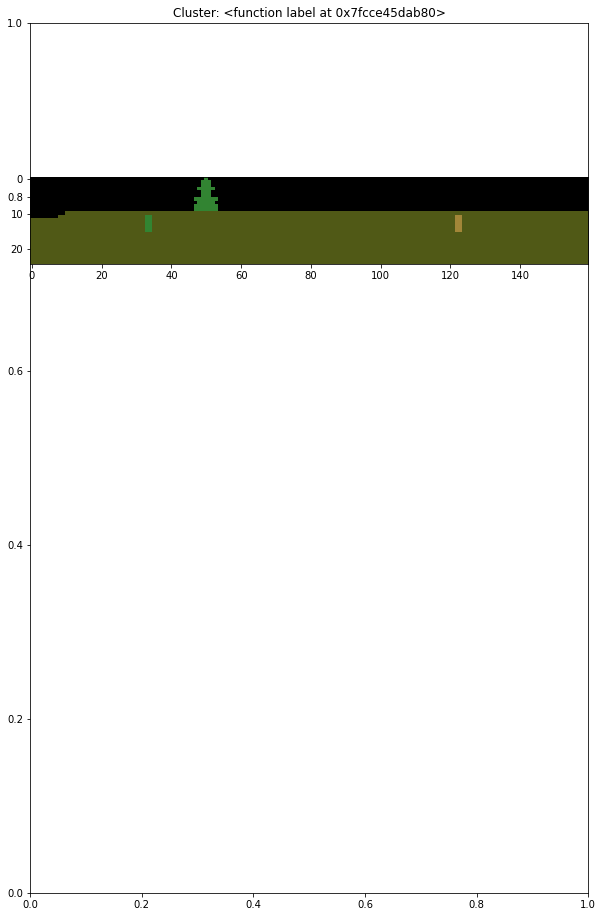

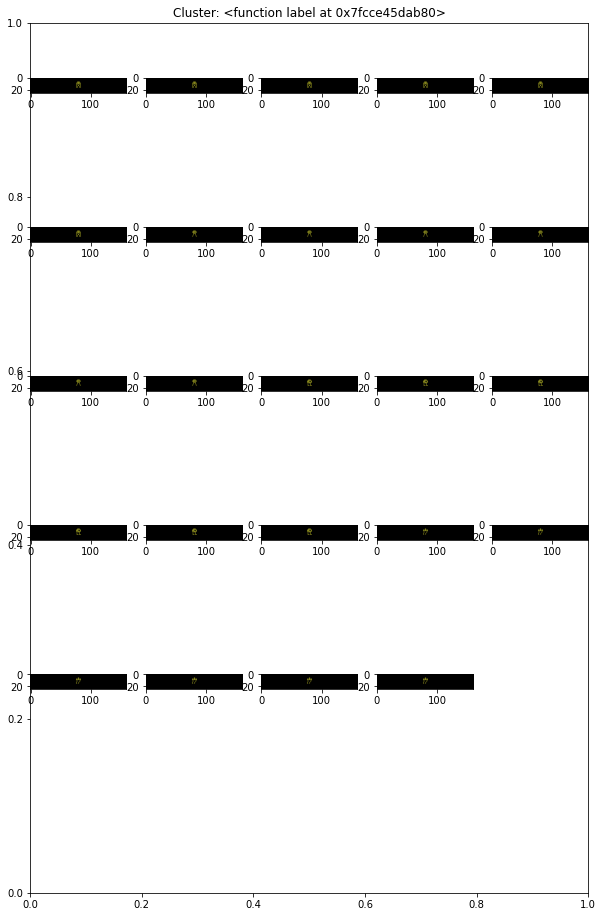

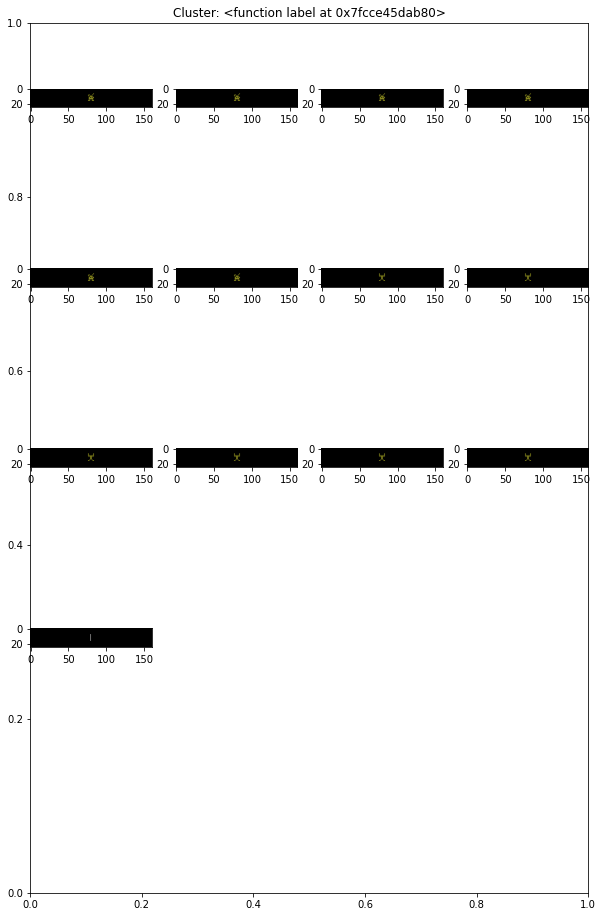

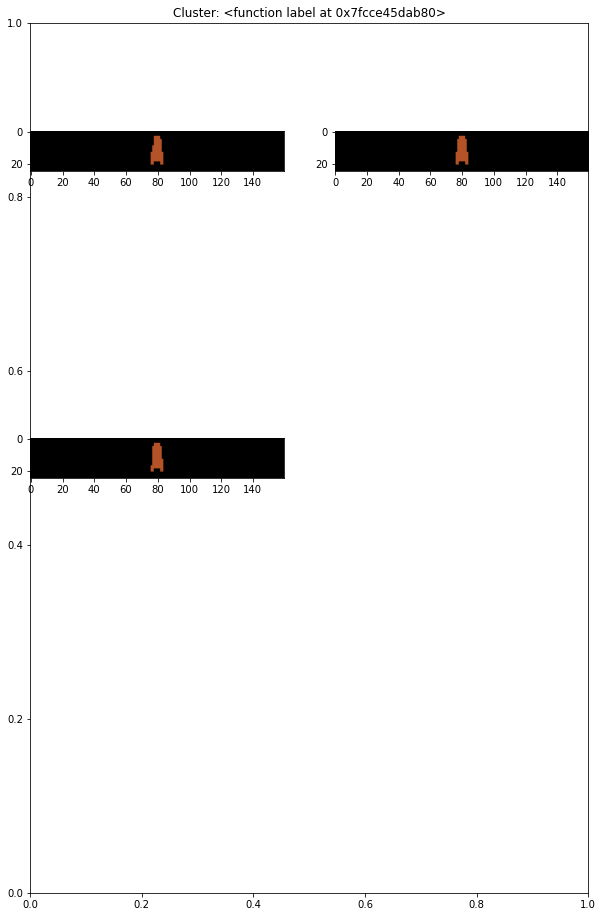

In [23]:
for l in np.unique(kmeans.labels_):
    fig = plt.figure(figsize=(10,16))
    plt.title("Cluster: "+str(label))
    i=1
    size=round(np.sqrt(sum(kmeans.labels_==l)))
    for ob in objects[(kmeans.labels_==l)]:
        fig.add_subplot(size+1, size,i)
        plt.imshow(ob)
        i+=1

# States Clustering

In [24]:
import networkx as nx

In [25]:
obj_mask=np.array([find_objects(x)>0 for x in States])

In [26]:
img = Image.fromarray(obj_mask[0])
#img.save("normal.png")
img.show()

<AxesSubplot:xlabel='x', ylabel='y'>

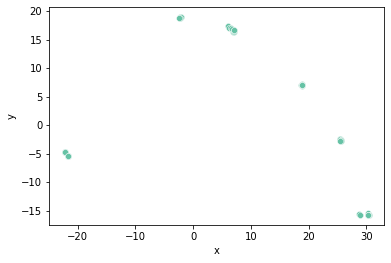

In [27]:
pca = PCA(n_components=50)

pca.fit(obj_mask.reshape(100,-1))

X = pca.transform(obj_mask.reshape(100,-1))

#visualize
df = pd.DataFrame(X[:,:2], columns=["x", "y"])
sns.scatterplot(data=df,x="x",y="y")

# X=pca.inverse_transform(X)

# X=X.reshape(obj_mask.shape)

# X=X.astype("uint8")

In [28]:
X.shape

(100, 50)

In [29]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)

In [30]:
lab=kmeans.labels_

In [31]:
Rewards=trace["reward"]

changes=np.where(lab[1:]!=lab[:-1])[0]

changes=np.concatenate(([0],changes,[len(Rewards)-1]))

In [32]:
changes

array([ 0, 42, 53, 63, 74, 86, 99])

In [33]:
G=nx.DiGraph()

In [34]:
for c in range(1,len(changes)-1):
    G.add_edge(lab[changes[c]],lab[changes[c+1]], weight=-np.sum(Rewards[changes[c-1]:changes[c]]))

G.add_edge(lab[changes[c+1]],-1, weight=-np.sum(Rewards[changes[c]:changes[c+1]]))

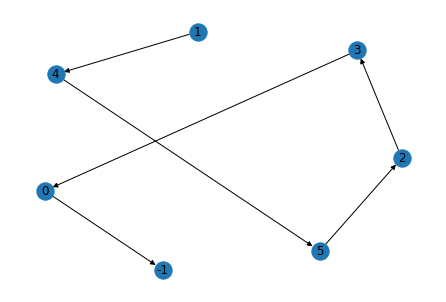

In [35]:
nx.draw(G,with_labels=True)

In [37]:
nx.shortest_path(G, source=1, target=5, weight="weight", method='dijkstra')

[1, 4, 5]

In [38]:
make_video(States[changes],"test2",fps=7)

In [39]:
trace2=np.load("./record/trace-000000004.npz")

In [40]:
States2=trace2["states"]

In [41]:
obj_mask2=np.array([find_objects(x)>0 for x in States2])

In [42]:
X = pca.transform(obj_mask2.reshape(100,-1))

In [43]:
kmeans.predict(X)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [44]:
lab=kmeans.predict(X)

Rewards2=trace2["reward"]

changes2=np.where(lab[1:]!=lab[:-1])[0]

changes2=np.concatenate(([0],changes2,[len(Rewards)-1]))

In [45]:
trace2["actions"]

array([4, 2, 1, 0, 0, 2, 3, 3, 1, 5, 3, 0, 1, 4, 2, 3, 0, 3, 5, 4, 3, 5,
       4, 1, 4, 1, 2, 5, 1, 1, 5, 0, 5, 5, 4, 1, 3, 1, 4, 3, 4, 5, 4, 3,
       0, 5, 3, 0, 5, 2, 2, 2, 2, 4, 0, 1, 1, 1, 5, 0, 0, 2, 4, 0, 3, 5,
       0, 2, 3, 4, 0, 3, 3, 2, 0, 1, 1, 3, 5, 3, 1, 2, 1, 5, 0, 0, 5, 5,
       3, 1, 2, 2, 5, 3, 5, 5, 1, 4, 4, 2])

In [46]:
trace["actions"]

array([5, 0, 4, 1, 3, 4, 3, 4, 0, 2, 1, 0, 1, 5, 4, 1, 2, 0, 4, 1, 0, 2,
       5, 4, 1, 3, 1, 4, 5, 2, 2, 4, 3, 4, 3, 4, 5, 0, 2, 2, 2, 1, 3, 3,
       1, 3, 0, 3, 2, 3, 4, 5, 3, 0, 3, 2, 2, 2, 4, 4, 2, 1, 1, 4, 4, 2,
       2, 2, 5, 0, 4, 0, 2, 5, 1, 3, 3, 3, 0, 5, 5, 5, 2, 3, 5, 0, 5, 4,
       0, 1, 2, 3, 5, 0, 0, 0, 0, 1, 1, 5])

In [47]:
for c in range(1,len(changes2)-1):
    G.add_edge(lab[changes2[c]],lab[changes2[c+1]], weight=-np.sum(Rewards[changes2[c-1]:changes2[c]]))

G.add_edge(lab[changes2[c+1]],-1, weight=-np.sum(Rewards[changes2[c]:changes2[c+1]]))

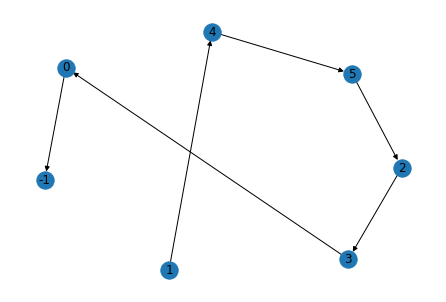

In [48]:
nx.draw(G,with_labels=True)

# Trees

In [69]:
# Imports
from skmultiflow.data import SEAGenerator
from skmultiflow.trees import HoeffdingTreeClassifier
# Setting up a data stream
stream = SEAGenerator(random_state=1)
# Setup Hoeffding Tree estimator
ht = HoeffdingTreeClassifier()
# Setup variables to control loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = 200
# Train the estimator with the samples provided by the data stream
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    y_pred = ht.predict(X)
    if y[0] == y_pred[0]:
        correct_cnt += 1
    ht = ht.partial_fit(X, y)
    n_samples += 1
# Display results
print('{} samples analyzed.'.format(n_samples))
print('Hoeffding Tree accuracy: {}'.format(correct_cnt / n_samples))

200 samples analyzed.
Hoeffding Tree accuracy: 0.945


In [59]:
ht = HoeffdingTreeClassifier()

In [66]:
X=obj_mask.reshape(100,-1)

In [70]:
#ht = ht.partial_fit(X, X)

In [55]:
ht.get_model_description()

'Leaf = Class 1 | {0: 56.0, 1: 144.0}\n'

In [57]:
print(ht.get_rules_description())

ass: 1



In [71]:
print(ht.get_model_description())

Leaf = Class 1 | {0: 56.0, 1: 144.0}



In [58]:
ht.get_model_rules()

[Rule(class_distribution=None, class_idx=1, drift_detector=None)]

In [106]:
# Setup the stream
stream = AGRAWALGenerator()
X, y = stream.next_sample(20000)
# Setup the learner
learner = HoeffdingTreeClassifier()
# Train
learner.partial_fit(X, y)
# Print rules
print(learner.get_model_description())
# Predict
X, y = stream.next_sample(100)
learner.predict(X)

if Attribute 2 <= 36.36363636363636:
  Leaf = Class 0 | {0: 5521.516267882114}
if Attribute 2 > 36.36363636363636:
  if Attribute 2 <= 60.45454545454545:
    if Attribute 2 <= 39.09090909090909:
      Leaf = Class 0 | {0: 952.3534640186198}
    if Attribute 2 > 39.09090909090909:
      if Attribute 2 <= 58.18181818181818:
        Leaf = Class 1 | {1: 5707.59420542183}
      if Attribute 2 > 58.18181818181818:
        if Attribute 2 <= 59.09090909090909:
          Leaf = Class 1 | {1: 275.0}
        if Attribute 2 > 59.09090909090909:
          Leaf = Class 0 | {0: 276.0}
  if Attribute 2 > 60.45454545454545:
    Leaf = Class 0 | {0: 6285.275136305439}



array([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1])

In [101]:
from skmultiflow.rules import VeryFastDecisionRulesClassifier
from skmultiflow.data import AGRAWALGenerator
# Setup the stream
stream = AGRAWALGenerator()
X, y = stream.next_sample(20000)
# Setup the learner
learner = VeryFastDecisionRulesClassifier(ordered_rules=False)
# Train
learner.partial_fit(X, y)
# Print rules
print(learner.get_model_description())
# Predict
X, y = stream.next_sample(100)
learner.predict(X)

No Nominal attributes have been defined, will consider all attributes as numerical
Rule 0 :Att (2) <= 36.360| class :0  {0: 5576.6702283655395}
Rule 1 :Att (2) > 60.450| class :0  {0: 6304.473710946984}
Rule 2 :Att (2) <= 39.090| class :0  {0: 5864.713041885753}
Rule 3 :Att (2) > 60.910| class :0  {0: 5626.952614493953}
Rule 4 :Att (2) > 58.180 and Att (2) <= 59.090| class :1  {1: 207.0}
Rule 5 :Att (2) <= 39.640| class :0  {0: 2016.0}
Rule 6 :Att (2) <= 37.000| class :0  {0: 1574.0}
Rule 7 :Att (2) <= 39.820 and Att (2) > 37.820| class :0  {0: 169.0}
Rule 8 :Att (2) > 60.910| class :0  {0: 1130.0314519660838}
Rule 9 :Att (2) > 58.180| class :0  {0: 134.0, 1: 5.0}
Default Rule :| class :1  {1: 1089.0}


/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/skmultiflow/rules/very_fast_decision_rules.py:837: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(predictions)


array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [108]:
r=learner.get_model_rules()[2]

In [109]:
r.get_rule()

'Att (2) > 36.360 and Att (2) <= 60.450 and Att (2) > 39.090 and Att (2) <= 58.180 | class: 1'

# Ontology

In [396]:
onto = owl.get_ontology("http://test.org/onto.owl")

In [84]:
onto

get_ontology("http://test.org/onto.owl#")

In [436]:
class State(owl.Thing):
    namespace = onto

In [437]:
class Action(owl.Thing):
    namespace = onto

In [438]:
class from_state_action(owl.ObjectProperty):
    namespace = onto
    domain = [State]
    range  = [Action]

In [439]:
class to_state_action(owl.ObjectProperty):
    namespace = onto
    domain = [Action]
    range  = [State]

In [445]:
with onto:
    class object_representant(owl.DataProperty):
        domain = [Object]
        range = [str]

In [449]:
with onto:
    class object_position_x(owl.DataProperty):
        domain = [Object]
        range = [int]

In [450]:
with onto:
    class object_position_y(owl.DataProperty):
        domain = [Object]
        range = [int]

In [446]:
class Object(owl.Thing):
    namespace = onto

In [460]:
regions[0].bbox

(10, 4, 19, 16)

In [464]:
kmeans.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       0, 0, 0], dtype=int32)

In [466]:
my_object = Object("my_object", namespace = onto, object_representant = ["rep"],object_position_x=[0],object_position_y=[0])

In [467]:
onto.my_object.get_properties()

{einsteins_riddle.object_representant,
 einsteins_riddle.object_position_x,
 einsteins_riddle.object_position_y}

# Reasoning

In [418]:
onto = owl.get_ontology("file://einsteins_riddle.rdf").load()

# Grounding

In [419]:
onto.name

'einsteins_riddle'

In [420]:
list(onto.classes())

[owl.Nothing,
 einsteins_riddle.owl.Beverage,
 einsteins_riddle.owl.Man,
 einsteins_riddle.owl.Color,
 einsteins_riddle.owl.House,
 einsteins_riddle.owl.Pet,
 einsteins_riddle.owl.Cigarette]

In [421]:
list(onto.individuals())

[einsteins_riddle.owl.orange_juice,
 einsteins_riddle.owl.tea,
 einsteins_riddle.owl.water,
 einsteins_riddle.owl.coffee,
 einsteins_riddle.owl.milk,
 einsteins_riddle.owl.Kools,
 einsteins_riddle.owl.Lucky_Strike,
 einsteins_riddle.owl.Parliaments,
 einsteins_riddle.owl.Chesterfields,
 einsteins_riddle.owl.Old_Gold,
 einsteins_riddle.owl.green,
 einsteins_riddle.owl.red,
 einsteins_riddle.owl.blue,
 einsteins_riddle.owl.yellow,
 einsteins_riddle.owl.ivory,
 einsteins_riddle.owl.house-2,
 einsteins_riddle.owl.house-3,
 einsteins_riddle.owl.house-1,
 einsteins_riddle.owl.house-4,
 einsteins_riddle.owl.house-5,
 einsteins_riddle.owl.Ukrainian,
 einsteins_riddle.owl.Spaniard,
 einsteins_riddle.owl.Norwegian,
 einsteins_riddle.owl.Englishman,
 einsteins_riddle.owl.Japanese,
 einsteins_riddle.owl.zebra,
 einsteins_riddle.owl.horse,
 einsteins_riddle.owl.snails,
 einsteins_riddle.owl.dog,
 einsteins_riddle.owl.fox]

In [422]:
list(onto.properties())

[einsteins_riddle.owl.drinks,
 einsteins_riddle.owl.has_color,
 einsteins_riddle.owl.lives_in,
 einsteins_riddle.owl.owns,
 einsteins_riddle.owl.right_to,
 einsteins_riddle.owl.smokes,
 1.1.description,
 1.1.date,
 1.1.creator]

In [423]:
list(onto.object_properties())

[einsteins_riddle.owl.drinks,
 einsteins_riddle.owl.has_color,
 einsteins_riddle.owl.lives_in,
 einsteins_riddle.owl.owns,
 einsteins_riddle.owl.right_to,
 einsteins_riddle.owl.smokes]

In [424]:
list(onto.disjoints())

[AllDisjoint([einsteins_riddle.owl.Chesterfields, einsteins_riddle.owl.Englishman, einsteins_riddle.owl.Japanese, einsteins_riddle.owl.Kools, einsteins_riddle.owl.Lucky_Strike, einsteins_riddle.owl.Norwegian, einsteins_riddle.owl.Old_Gold, einsteins_riddle.owl.Parliaments, einsteins_riddle.owl.Spaniard, einsteins_riddle.owl.Ukrainian, einsteins_riddle.owl.blue, einsteins_riddle.owl.coffee, einsteins_riddle.owl.dog, einsteins_riddle.owl.fox, einsteins_riddle.owl.green, einsteins_riddle.owl.horse, einsteins_riddle.owl.house-1, einsteins_riddle.owl.house-2, einsteins_riddle.owl.house-3, einsteins_riddle.owl.house-4, einsteins_riddle.owl.house-5, einsteins_riddle.owl.ivory, einsteins_riddle.owl.milk, einsteins_riddle.owl.orange_juice, einsteins_riddle.owl.red, einsteins_riddle.owl.snails, einsteins_riddle.owl.tea, einsteins_riddle.owl.water, einsteins_riddle.owl.yellow, einsteins_riddle.owl.zebra], ontology = get_ontology("http://persons.iis.nsk.su/files/persons/pages/einsteins_riddle.owl#

In [426]:
with onto:
    owl.sync_reasoner(infer_property_values = True)

* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/owlready2/hermit:/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////tmp/tmpwhqkkfrx -Y


* Owlready * Adding relation einsteins_riddle.owl.Norwegian smokes einsteins_riddle.owl.Kools
* Owlready * Adding relation einsteins_riddle.owl.Ukrainian smokes einsteins_riddle.owl.Chesterfields
* Owlready * Adding relation einsteins_riddle.owl.Spaniard smokes einsteins_riddle.owl.Lucky_Strike
* Owlready * Adding relation einsteins_riddle.owl.Englishman smokes einsteins_riddle.owl.Old_Gold
* Owlready * Adding relation einsteins_riddle.owl.Norwegian owns einsteins_riddle.owl.fox
* Owlready * Adding relation einsteins_riddle.owl.Ukrainian owns einsteins_riddle.owl.horse
* Owlready * Adding relation einsteins_riddle.owl.Englishman owns einsteins_riddle.owl.snails
* Owlready * Adding relation einsteins_riddle.owl.Japanese owns einsteins_riddle.owl.zebra
* Owlready * Adding relation einsteins_riddle.owl.Norwegian drinks einsteins_riddle.owl.water
* Owlready * Adding relation einsteins_riddle.owl.Spaniard drinks einsteins_riddle.owl.orange_juice
* Owlready * Adding relation einsteins_riddle

* Owlready2 * HermiT took 1.7078933715820312 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [427]:
query = owl.default_world.prepare_sparql("""SELECT ?house ?man Where{ ?house a einsteins_riddle:House. ?man a einsteins_riddle:Man. ?man einsteins_riddle:lives_in ?house. 
}""")

In [428]:
list(query.execute())

[[einsteins_riddle.owl.house-2, einsteins_riddle.owl.Ukrainian],
 [einsteins_riddle.owl.house-4, einsteins_riddle.owl.Spaniard],
 [einsteins_riddle.owl.house-1, einsteins_riddle.owl.Norwegian],
 [einsteins_riddle.owl.house-1, einsteins_riddle.owl.Norwegian],
 [einsteins_riddle.owl.house-3, einsteins_riddle.owl.Englishman],
 [einsteins_riddle.owl.house-5, einsteins_riddle.owl.Japanese]]